<a href="https://colab.research.google.com/github/thor4/neuralnets/blob/master/projects/1-CNN/step1-train_cifar10_cnn_tl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create CNN Trained on CIFAR10 then Fine-tuned for Gabor Classification
### Adapted from [Convolutional Neural Network (CNN) Tensorflow tutorial](https://www.tensorflow.org/tutorials/images/cnn).
--- 
##Create & Train the CNN

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Mar 16 00:43:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


### Import libraries

In [3]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import os
import numpy as np

### Load and prepare the data
The dataset is comprised of 60,000 color images in 10 classes, with 6,000 images in each class. There are 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

500 Gabors were generated for each of the 18 groups for each of the 2 classes (500 x 18 x 2 = 18,000 total images). The dataset is divided into 11,988 training images, 4,788 validation images, and 1,224 testing images. The batch size was set at 32 and image size at 160 x 160.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


In [ ]:
print(train_images.shape)
print(train_labels.shape)

(50000, 32, 32, 3)
(50000, 1)


###Normalize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general we should seek to make our input values small. We will normalize values to be in the [0, 1] range by dividing by 255.

In [ ]:
train_images, test_images = train_images / 255.0, test_images / 255.0

### Verify the data
To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:

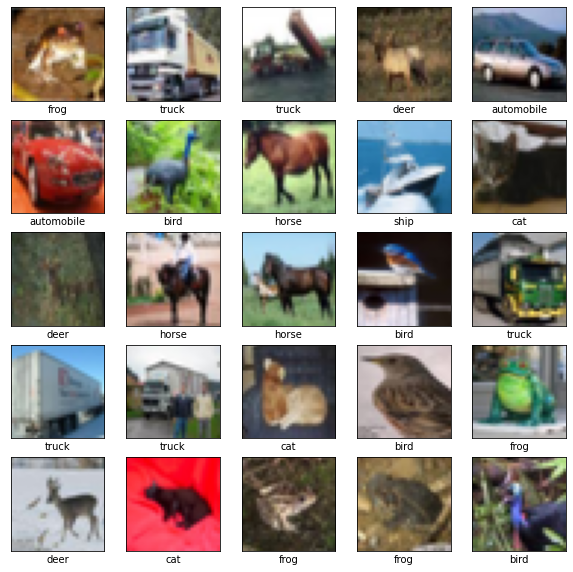

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

Resize the first 25 images to match the size the vanilla model expects (160, 160) and plot to confirm images are the same.

In [ ]:
train_images_big = tf.image.resize(train_images[0:26], (160,160))
train_images_big.shape

TensorShape([26, 160, 160, 3])

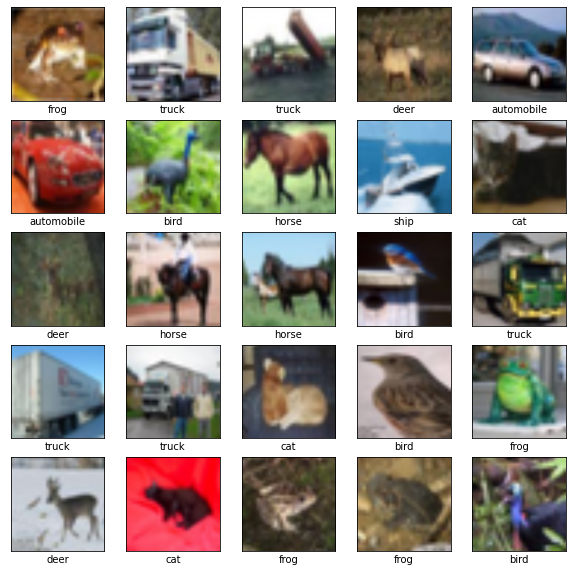

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images_big[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [ ]:
print(f"confirming [0,1] normalization:",np.min(train_images_big[1]),np.max(train_images_big[1]))

confirming [0,1] normalization: 0.019607844 0.99607843


Now, resize all training and testing images and confirm shape. Due to Colab memory constraints (even using Pro), we must restart environment and skip to this step after loading data, but before normalizing. We add a layer in the model to take care of normalizing the input data.

In [ ]:
train_images_big = tf.image.resize(train_images, (160,160))
test_images_big = tf.image.resize(test_images, (160,160))
print(train_images_big.shape)
print(test_images_big.shape)

(50000, 160, 160, 3)
(10000, 160, 160, 3)


### Create the model

The first 3 lines of code below instantiate the Sequential model definition, declare the input shape of the images then apply the normalization layer.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. color_channels refers to (R,G,B). We will configure the CNN to process inputs of shape (160, 160, 3), which is the format of our CIFAR10 images and later, Gabors. We can do this by passing the argument `input_shape` to the first layer titled `InputLayer`.

The next 5 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

To complete the model, we will feed the last output tensor from the convolutional base (of shape (36, 36, 320)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, we will flatten (or unroll) the 3D output to 1D, then add one or more Dense layers on top. Our dataset has 2 output classes, so we use a final Dense layer with a single logit output prediction.

In [ ]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(160,160,3)))
model.add(layers.experimental.preprocessing.Rescaling(1./255)) #normalization layer
model.add(layers.Conv2D(160, (3, 3), activation='relu', input_shape=(160, 160, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(80, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten()) #flatten from 3d output to 1d
model.add(layers.Dense(80, activation='relu'))
model.add(layers.Dense(10))

Let's display the architecture of the model so far:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 158, 158, 160)     4480      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 160)      0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 39, 39, 160)      0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 80)        115280    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 80)       0

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as we go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 160 or 80). 

Finally, we see that (18, 18, 80) outputs were flattened into vectors of shape (25920) before going through two Dense layers.

### Compile and train the model

We will define the learning rate and use the BinaryCrossEntropy loss since the model provides a single linear output

In [ ]:
test_labels.shape

(10000, 1)

In [ ]:
base_learning_rate = 0.0001 #define the learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

history = model.fit(train_images_big, 
                    train_labels, 
                    epochs=10, 
                    validation_data=(test_images_big, test_labels))
#tests against test dataset after each iteration

Epoch 1/10
1563/1563 [==============================] - 64s 35ms/step - loss: 1.6206 - accuracy: 0.4255 - val_loss: 1.4557 - val_accuracy: 0.4896
Epoch 2/10
1563/1563 [==============================] - 54s 35ms/step - loss: 1.2687 - accuracy: 0.5527 - val_loss: 1.2431 - val_accuracy: 0.5670
Epoch 3/10
1563/1563 [==============================] - 54s 34ms/step - loss: 1.1583 - accuracy: 0.5934 - val_loss: 1.1905 - val_accuracy: 0.5857
Epoch 4/10
1563/1563 [==============================] - 55s 35ms/step - loss: 1.0850 - accuracy: 0.6190 - val_loss: 1.1278 - val_accuracy: 0.6022
Epoch 5/10
1563/1563 [==============================] - 54s 35ms/step - loss: 1.0270 - accuracy: 0.6398 - val_loss: 1.0993 - val_accuracy: 0.6171
Epoch 6/10
1563/1563 [==============================] - 55s 35ms/step - loss: 0.9828 - accuracy: 0.6558 - val_loss: 1.1030 - val_accuracy: 0.6163
Epoch 7/10
1563/1563 [==============================] - 54s 35ms/step - loss: 0.9382 - accuracy: 0.6704 - val_loss: 1.0826 -

### Evaluate the model
Let's make a plot to visualize how the training and validation accuracy improves with each epoch. We will also evaluate the model against the test dataset.

313/313 - 5s - loss: 1.0943 - accuracy: 0.6282 - 5s/epoch - 15ms/step


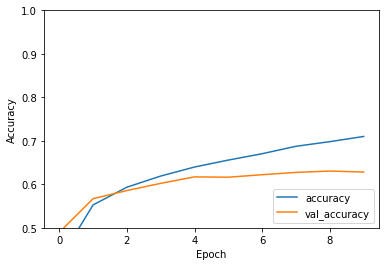

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images_big,  test_labels, verbose=2)

The model achieved a 62.82% accuracy on the test set after 10 epochs. Now let's save our cifar10 CNN model.

In [ ]:
model.save('cifar10')

INFO:tensorflow:Assets written to: cifar10/assets


In [ ]:
os.getcwd()

'/content'

In [ ]:
! zip -r cifar10_model.zip cifar10/

  adding: cifar10/ (stored 0%)
  adding: cifar10/variables/ (stored 0%)
  adding: cifar10/variables/variables.data-00000-of-00001 (deflated 22%)
  adding: cifar10/variables/variables.index (deflated 64%)
  adding: cifar10/saved_model.pb (deflated 88%)
  adding: cifar10/keras_metadata.pb (deflated 91%)
  adding: cifar10/assets/ (stored 0%)


## Transfer Learning
Now we will transfer the learning from the cifar10 dataset over to a Gabor classification task.

In [ ]:
del model

In [4]:
# @title Download model

import requests, os
from zipfile import ZipFile

print("Start downloading and unzipping `Cifar10 model`...")
name = 'cifar10_model'
fname = f"{name}.zip"
url = f"https://osf.io/kj2p8/download" #osf share link
r = requests.get(url, allow_redirects=True)
with open(fname, 'wb') as fh:
  fh.write(r.content) #download file

with ZipFile(fname, 'r') as zfile:
  zfile.extractall() #extract contents

if os.path.exists(fname):
  os.remove(fname) #delete zip file
else:
  print(f"The file {fname} does not exist")

print("Download completed.")

Start downloading and unzipping `Cifar10 model`...
Download completed.


In [5]:
cifar_model = tf.keras.models.load_model('cifar10')

In [6]:
cifar_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 158, 158, 160)     4480      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 160)      0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 39, 39, 160)      0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 80)        115280    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 80)       0

### Load and prepare the data
The dataset is comprised of 21,000 total Gabors in two classes representing tilts from 45 degrees in the clockwise direction and tilts in the counterclockwise direction. The Gabors were generated in MATLAB using gen_gabor-range_random.m which used a range of 3 contrasts with random tilts from [0.05, 2]. 
- `tilts = rand[0.05,2]; # measured in degrees`
- `contrasts = [.3, .45, 1];  # measured in percent`  

3500 Gabors were generated for each of the 3 contrasts for each of the 2 classes (3500 x 3 x 2 = 21,000 total images). The dataset is divided into 13,998 training images, 5,598 validation images, and 1,404 testing images. 

We will download a zip file from OSF then extract its contents and change into the newly created directory: `content/model_training-range_con_rand_tilt/`

In [7]:
# @title Load data

import requests, os
from zipfile import ZipFile

print("Start downloading and unzipping Training dataset...")
name = 'model_training-range_con_rand_tilt_0_5-4'
fname = f"{name}.zip"
url = f"https://osf.io/m78kc/download" #osf share link
r = requests.get(url, allow_redirects=True)
with open(fname, 'wb') as fh:
  fh.write(r.content) #download file

with ZipFile(fname, 'r') as zfile:
  zfile.extractall(f"./{name}") #extract contents

if os.path.exists(fname):
  os.remove(fname) #delete zip file
else:
  print(f"The file {fname} does not exist")

os.chdir(name) #move into extracted folder root
print("Download completed.")

Start downloading and unzipping Training dataset...
Download completed.


After downloading, we can load the data into datasets structured for training a neural network. The batch size will be set at 32 and image size at 160 x 160. 

In [8]:
def load_data():
    curr_dir = os.getcwd() 
    train_dir = os.path.join(curr_dir, 'train_range_rand')
    validation_dir = os.path.join(curr_dir, 'valid_range_rand')
    test_dir = os.path.join(curr_dir, 'test_range_rand')
    BATCH_SIZE = 32 
    IMG_SIZE = (160, 160)
    IMG_SHAPE = IMG_SIZE + (3,) #adds a third dimension to hold 3 color channels
    train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE) 
    validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE) 
    test_dataset = image_dataset_from_directory(test_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE) 
    class_names = train_dataset.class_names #assign clockwise (clock) & counterclockwise (cclock) classes
    return BATCH_SIZE,IMG_SIZE,train_dataset,validation_dataset,test_dataset,IMG_SHAPE,class_names

BATCH_SIZE, IMG_SIZE, train_dataset, validation_dataset, test_dataset, IMG_SHAPE, class_names = load_data()

Found 13998 files belonging to 2 classes.
Found 5598 files belonging to 2 classes.
Found 1404 files belonging to 2 classes.


Confirm the images are 3 channel (rgb) of 160x160

In [9]:
train_dataset.element_spec

(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

### Verify the data
To verify that the dataset looks correct, let's plot the first 9 images from the training set and display the class name above each image.

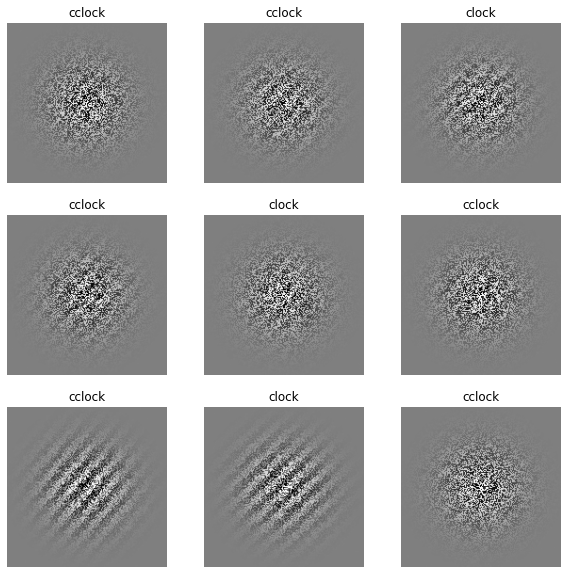

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1): #load first iteration batch from training dataset
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1) #setup axis on a 3x3 grid
    plt.imshow(images[i].numpy().astype("uint8"),cmap='gray') #plot each image
    plt.title(class_names[labels[i]]) #output associated label for chosen image
    plt.axis("off")

### Setup buffered prefetching
We can configure the dataset for performance using buffered prefetching to load images from disk without having I/O become blocking

In [11]:
def prefetch(train_dataset, validation_dataset, test_dataset):
    AUTOTUNE = tf.data.AUTOTUNE #prompts the tf.data runtime to tune the value dynamically at runtime
    train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE) #will prefetch an optimal number of batches
    validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE) #will prefetch an optimal number of batches
    test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE) #will prefetch an optimal number of batches
    return train_dataset,validation_dataset,test_dataset,AUTOTUNE

train_dataset, validation_dataset, test_dataset, AUTOTUNE = prefetch(train_dataset, validation_dataset, test_dataset)

###Add final layers to model

Trim off the last few top layers and freeze the weights.

In [12]:
base_model = tf.keras.models.Sequential(cifar_model.layers[:-1])
base_model.trainable = False

In [13]:
#global_average_layer = tf.keras.layers.GlobalAveragePooling2D() #create layer
prediction_layer = tf.keras.layers.Dense(1) #create a densely-connected NN layer with a single logit output prediction

In [14]:
inputs = tf.keras.Input(shape=IMG_SHAPE) #ensure input size is one of the predefined VGG16 requires
x = base_model(inputs)
#x = global_average_layer(x) 
#x = tf.keras.layers.Dropout(0.2)(x) 
outputs = prediction_layer(x) #define output as single prediction
model = tf.keras.Model(inputs, outputs) #build the model

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 80)                2193440   
                                                                 
 dense (Dense)               (None, 1)                 81        
                                                                 
Total params: 2,193,521
Trainable params: 81
Non-trainable params: 2,193,440
_________________________________________________________________


###Train the model & save it
The 513 trainable parameters are divided between 2 tf.variables: weights (80) & a bias (1)

In [16]:
base_learning_rate = 0.001 #define the learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #use this loss since model provides a linear output
              metrics=['accuracy'])
len(model.trainable_variables)

2

Let's see how the model performs prior to training by processing the validation set.

In [17]:
loss0, accuracy0 = model.evaluate(validation_dataset) 
print("initial loss: {:.2f}".format(loss0)) 
print("initial accuracy: {:.2f}".format(accuracy0))

175/175 [==============================] - 12s 17ms/step - loss: 4.0141 - accuracy: 0.5000
initial loss: 4.01
initial accuracy: 0.50


As expected, the loss is quite high at 4.01 and the accuracy is chance at 0.50.

In [18]:
initial_epochs = 10 #define training epochs
history = model.fit(train_dataset, 
                    epochs=initial_epochs, 
                    validation_data=validation_dataset)

Epoch 1/10
438/438 [==============================] - 11s 24ms/step - loss: 0.9504 - accuracy: 0.5321 - val_loss: 0.6687 - val_accuracy: 0.5536
Epoch 2/10
438/438 [==============================] - 11s 24ms/step - loss: 0.6607 - accuracy: 0.5305 - val_loss: 0.6492 - val_accuracy: 0.5693
Epoch 3/10
438/438 [==============================] - 10s 24ms/step - loss: 0.6413 - accuracy: 0.5376 - val_loss: 0.6287 - val_accuracy: 0.5600
Epoch 4/10
438/438 [==============================] - 11s 24ms/step - loss: 0.6221 - accuracy: 0.5533 - val_loss: 0.6118 - val_accuracy: 0.5786
Epoch 5/10
438/438 [==============================] - 11s 24ms/step - loss: 0.6060 - accuracy: 0.5767 - val_loss: 0.5963 - val_accuracy: 0.5870
Epoch 6/10
438/438 [==============================] - 11s 24ms/step - loss: 0.5919 - accuracy: 0.6034 - val_loss: 0.5841 - val_accuracy: 0.6293
Epoch 7/10
438/438 [==============================] - 11s 24ms/step - loss: 0.5806 - accuracy: 0.6272 - val_loss: 0.5734 - val_accuracy:

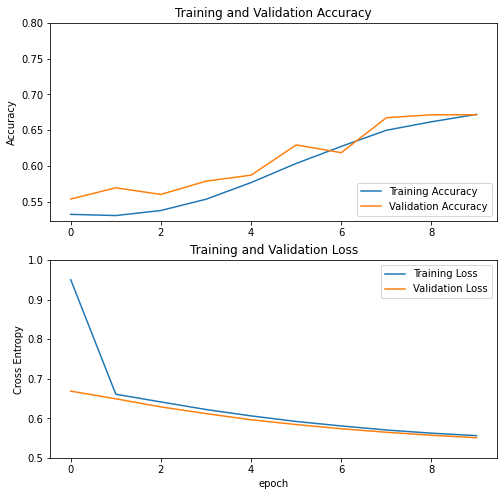

In [19]:
acc = history.history['accuracy'] #extract and store history of accuracy scores on training set as list
val_acc = history.history['val_accuracy'] #extract and store history of accuracy scores on validation set as list
loss = history.history['loss'] #extract and store history of loss scores on training set as list
val_loss = history.history['val_loss'] #extract and store history of losss scores on validation set as list
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.8])
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0.5,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show() #accuracy trends up over time and the loss goes down

In [20]:
loss1, accuracy1 = model.evaluate(test_dataset) 
print("test loss: {:.2f}".format(loss1)) 
print("test accuracy: {:.2f}".format(accuracy1))

44/44 [==============================] - 1s 18ms/step - loss: 0.5514 - accuracy: 0.6617
test loss: 0.55
test accuracy: 0.66


66% accuracy on the test set. Let's save this model.

In [21]:
model.save('cifar10_gabors')

INFO:tensorflow:Assets written to: cifar10_gabors/assets


In [22]:
! zip -r cifar10_gabors_model.zip cifar10_gabors/

  adding: cifar10_gabors/ (stored 0%)
  adding: cifar10_gabors/assets/ (stored 0%)
  adding: cifar10_gabors/saved_model.pb (deflated 89%)
  adding: cifar10_gabors/keras_metadata.pb (deflated 92%)
  adding: cifar10_gabors/variables/ (stored 0%)
  adding: cifar10_gabors/variables/variables.index (deflated 56%)
  adding: cifar10_gabors/variables/variables.data-00000-of-00001 (deflated 7%)
